#Parkinson's Disease Cerebral Radio Images Classification
##Using the following CNNs: VGG16, Inception V3, DenseNet121

In [2]:
#Importing libraries needed
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

##Importing and Loading the Images Dataset

In [3]:
#Downloading the dataset from gihub
! git clone https://github.com/kaltisami/parkinsons_dataset.git

Cloning into 'parkinsons_dataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 17.58 MiB | 20.25 MiB/s, done.


In [4]:
! unzip parkinsons_dataset/parkinsons.zip

Archive:  parkinsons_dataset/parkinsons.zip
   creating: parkinsons/
  inflating: __MACOSX/._parkinsons   
  inflating: parkinsons/.DS_Store    
  inflating: __MACOSX/parkinsons/._.DS_Store  
   creating: parkinsons/non_parkinsons/
  inflating: __MACOSX/parkinsons/._non_parkinsons  
   creating: parkinsons/parkinsons/
  inflating: __MACOSX/parkinsons/._parkinsons  
   creating: parkinsons/.ipynb_checkpoints/
  inflating: parkinsons/non_parkinsons/case212.png  
  inflating: __MACOSX/parkinsons/non_parkinsons/._case212.png  
  inflating: parkinsons/non_parkinsons/3008.png  
  inflating: __MACOSX/parkinsons/non_parkinsons/._3008.png  
  inflating: parkinsons/non_parkinsons/case206.png  
  inflating: __MACOSX/parkinsons/non_parkinsons/._case206.png  
  inflating: parkinsons/non_parkinsons/3544.png  
  inflating: __MACOSX/parkinsons/non_parkinsons/._3544.png  
  inflating: parkinsons/non_parkinsons/3222.png  
  inflating: __MACOSX/parkinsons/non_parkinsons/._3222.png  
  inflating: parkinso

In [5]:
#Define paths to your dataset
dataset_dir = "parkinsons"
parkinsons_dir = os.path.join(dataset_dir, "parkinsons")
non_parkinsons_dir = os.path.join(dataset_dir, "non_parkinsons")

In [6]:
# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images

In [7]:
# Load images from Parkinson's and non-Parkinson's directories
parkinsons_images = load_images_from_folder(parkinsons_dir)
non_parkinsons_images = load_images_from_folder(non_parkinsons_dir)

#Data Preprocessing

##Labeling the Dataset

In [8]:
# Combine images and create labels
X = np.array(parkinsons_images + non_parkinsons_images, dtype=object)
y = np.array([1] * len(parkinsons_images) + [0] * len(non_parkinsons_images), dtype=object)

##Splitting the Dataset into train and test

In [9]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#resizing images to a common size (224x224)
IMG_SIZE = 224
X_train_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_test])

In [11]:
# Normalization
X_train_resized = X_train_resized.astype('float32') / 255.0
X_test_resized = X_test_resized.astype('float32') / 255.0

In [12]:
# Convert labels to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
# Check the shape of the datasets
print("Training data shape:", X_train_resized.shape)
print("Testing data shape:", X_test_resized.shape)
print("Training labels shape:", y_train_one_hot.shape)
print("Testing labels shape:", y_test_one_hot.shape)

Training data shape: (849, 224, 224, 3)
Testing data shape: (213, 224, 224, 3)
Training labels shape: (849, 2)
Testing labels shape: (213, 2)


#Exploratory Data Analysis

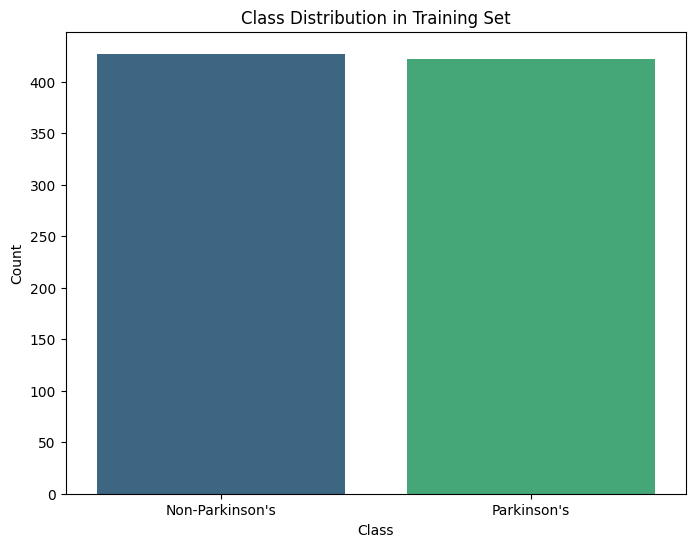

In [15]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, hue=y_train, palette='viridis', legend=False)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Parkinson\'s', 'Parkinson\'s'])
plt.show()

In [16]:
# Compute image statistics
mean_intensity = np.mean(X_train_resized)
median_intensity = np.median(X_train_resized)
std_intensity = np.std(X_train_resized)
min_intensity = np.min(X_train_resized)
max_intensity = np.max(X_train_resized)

# Print image statistics
print("Image Statistics:")
print("Mean Intensity:", mean_intensity)
print("Median Intensity:", median_intensity)
print("Standard Deviation Intensity:", std_intensity)
print("Min Intensity:", min_intensity)
print("Max Intensity:", max_intensity)

Image Statistics:
Mean Intensity: 0.1255086
Median Intensity: 0.08627451
Standard Deviation Intensity: 0.12930466
Min Intensity: 0.0
Max Intensity: 1.0


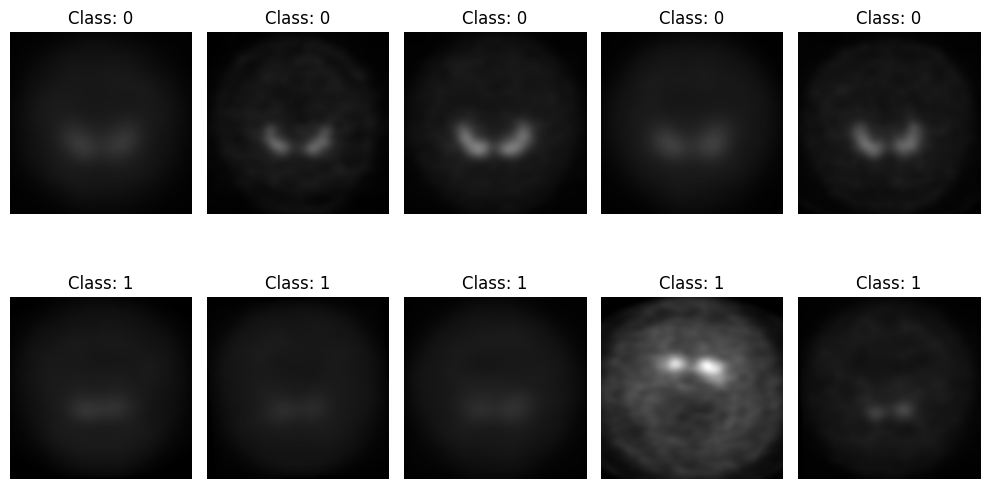

In [17]:
# Visualize sample images from each class separately
num_samples_per_class = 5

plt.figure(figsize=(10, 6))
for i in range(2):  # Loop over classes
    class_images = X_train_resized[y_train == i]
    sample_indices = np.random.choice(len(class_images), num_samples_per_class, replace=False)
    sample_images = class_images[sample_indices]
    for j, image in enumerate(sample_images):  # Loop over sample images per class
        plt.subplot(2, num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(image)
        plt.title('Class: {}'.format(i))
        plt.axis('off')
plt.tight_layout()
plt.show()

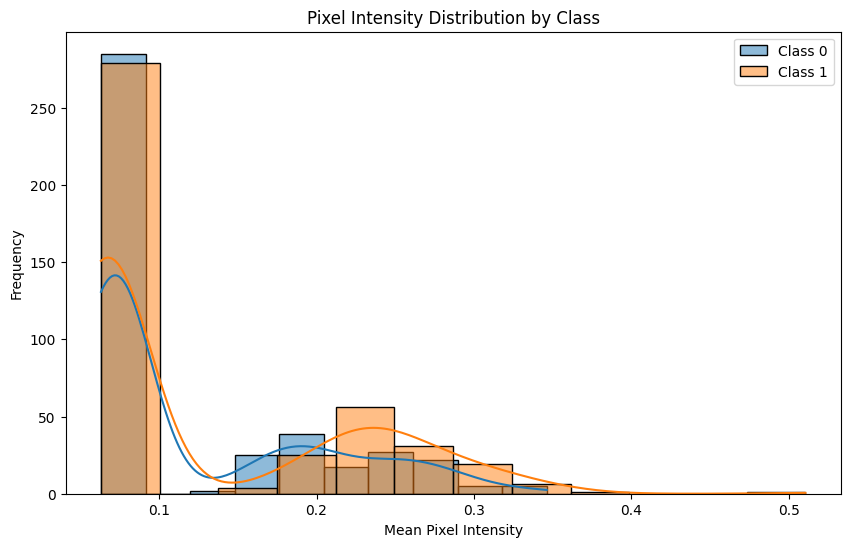

In [18]:
# Pixel intensity distribution by class
plt.figure(figsize=(10, 6))
for i in range(2):  # Loop over classes
    class_images = X_train_resized[y_train == i]
    class_mean_intensity = np.mean(class_images, axis=(1, 2, 3))  # Compute mean intensity for each image
    sns.histplot(class_mean_intensity, kde=True, label='Class {}'.format(i), alpha=0.5)
plt.title('Pixel Intensity Distribution by Class')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

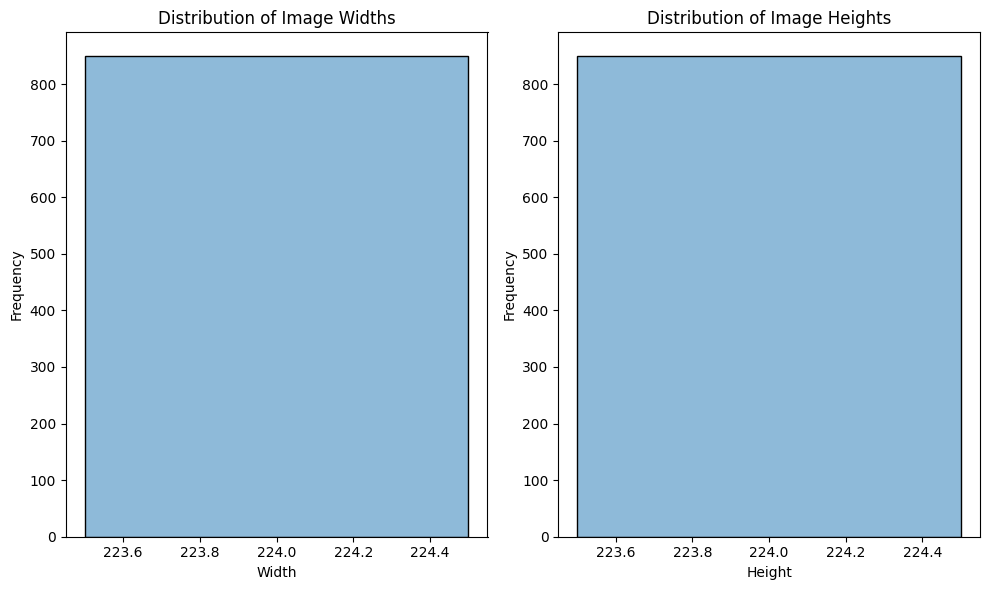

In [19]:
# Image dimension analysis
image_dimensions = np.array([img.shape[:2] for img in X_train_resized])
widths = image_dimensions[:, 0]
heights = image_dimensions[:, 1]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
# Convert one-hot encoded labels to binary labels
y_train_binary = np.argmax(y_train_one_hot, axis=1)
y_test_binary = np.argmax(y_test_one_hot, axis=1)

#Defining The Models

#VGG16

In [21]:
def vgg16():
  # Load the VGG16 model without the top layer
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the convolutional base
  for layer in base_model.layers:
      layer.trainable = False

  # Create a new model on top
  model = Sequential([
      base_model,
      Flatten(),
      Dense(256, activation='relu'),
      Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

  # Define batch sizes and epochs to test
  batch_size = 32
  epoch = 15

  print(f"Training VGG16 with batch size {batch_size} and epochs {epoch}")

  # Train the model
  history = model.fit(
      X_train_resized,y_train_binary,
      batch_size=batch_size,
      epochs=epoch,
      validation_split=0.2
  )
  # Evaluate the model on the test set
  test_loss, test_accuracy = model.evaluate(X_test_resized, y_test_binary)
  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)

  return model,history,test_loss,test_accuracy

model1=vgg16

#Inception V3

In [22]:
def inceptionv3():
  # Load the pre-trained InceptionV3 model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model's layers
  base_model.trainable = False

  # Create a new model on top of the pre-trained base model
  model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(512, activation='relu'),
      Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Define batch sizes and epochs to test
  batch_size = 32
  epochs = 20

  print(f"Training VGG16 with batch size {batch_size} and epochs {epochs}")

  # Train the model
  history = model.fit(
      X_train_resized,y_train_binary,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.2
  )
  # Evaluate the model on the test set
  test_loss, test_accuracy = model.evaluate(X_test_resized, y_test_binary)
  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)

  return model,history,test_loss,test_accuracy

model2=inceptionv3

#DenseNet121

In [23]:
def densenet121():
  # Load pre-trained DenseNet model
  model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Adjust input shape as needed

  # Freeze the layers of the pre-trained model
  for layer in model.layers:
      layer.trainable = False

  # Flatten the output of the base model
  x = Flatten()(model.output)
  # Add a fully connected layer
  x = Dense(128, activation='relu')(x)
  # Add dropout for regularization
  #x = Dropout(0.5)(x)
  # Add output layer with appropriate activation function (e.g., sigmoid for binary classification)
  # Change the output layer to have 1 unit and sigmoid activation
  predictions = Dense(units=1, activation='sigmoid')(x)

  # Create a new model combining the base DenseNet model and custom classification layers
  model = Model(inputs=model.input, outputs=predictions)

  # Use 'binary_crossentropy' loss for binary classification
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Define batch sizes and epochs to test
  batch_size = 32
  epochs = 15

  print(f"Training VGG16 with batch size {batch_size} and epochs {epochs}")

  # Train the model
  history = model.fit(
      X_train_resized,y_train_binary,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.2
  )
  # Evaluate the model on the test set
  test_loss, test_accuracy = model.evaluate(X_test_resized, y_test_binary)

  return model,history,test_loss,test_accuracy

model3=densenet121

##Defining Metrics

In [24]:
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score

# Define a function to evaluate the model and calculate metrics
def evaluate_model(model, test_loss, train_accuracy, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.model.evaluate(X_test, y_test)
    model.test_loss = model.model.history['loss'][-1]
    model.test_accuracy = model.model.history['accuracy'][-1]


    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Convert probabilities to binary predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Create instances of TensorFlow/Keras metrics
    accuracy_metric = Accuracy()
    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = F1Score(num_classes=2)  # For binary classification

    # Update metrics with test data
    accuracy_metric.update_state(y_test, y_pred)
    precision_metric.update_state(y_test, y_pred)
    recall_metric.update_state(y_test, y_pred)
    f1_score_metric.update_state(y_test, y_pred)

    # Get metric values
    accuracy = accuracy_metric.result().numpy()
    precision = precision_metric.result().numpy()
    recall = recall_metric.result().numpy()
    f1_score = f1_score_metric.result().numpy()

    print("\nMetrics:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1_score)

##Training and Testing the models

In [25]:
#VGG16 with batch_size = 32 and epoch = 15
model1_instance=model1()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training VGG16 with batch size 32 and epochs 15
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 687ms/step - accuracy: 0.4814 - loss: 1.7836 - val_accuracy: 0.5529 - val_loss: 0.6547
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.5806 - loss: 0.6619 - val_accuracy: 0.7706 - val_loss: 0.6005
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7144 - loss: 0.5930 - val_accuracy: 0.8000 - val_loss: 0.5595
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.7711 - loss: 0.5507 - val_accuracy: 0.8647 - val_loss: 0.5277
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7638 - loss: 0.4971 - val_accuracy: 0.8059 - val_loss: 0.4956
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.8216 - loss: 0.4762 - val_accuracy: 0.7529 - val_loss: 0.4829
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.7754 - loss: 0.4588 - val_accuracy: 0.7647 - val_loss: 0.4468
Epoc

In [26]:
#Inception V3 with batch_size = 32 and epochs = 20
model2_instance=model2()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training VGG16 with batch size 32 and epochs 20
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 969ms/step - accuracy: 0.6853 - loss: 0.7794 - val_accuracy: 0.8765 - val_loss: 0.2916
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.8803 - loss: 0.2727 - val_accuracy: 0.8882 - val_loss: 0.2323
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8935 - loss: 0.2599 - val_accuracy: 0.8824 - val_loss: 0.2846
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9039 - loss: 0.2292 - val_accuracy: 0.9059 - val_loss: 0.2074
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9440 - loss: 0.1445 - val_accuracy: 0.9176 - val_loss: 0.1941
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9489 - loss: 0.1298 - val_accuracy: 0.9235 - val_loss: 0.1850
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9641 - loss: 0.1107 - val_accuracy: 0.9235 - val_loss: 0.1903
Epoch 8/2

In [27]:
#DenseNet121 with batch_size = 32 and epoch = 15
model3_instance=model3()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training VGG16 with batch size 32 and epochs 15
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6553 - loss: 4.6803 - val_accuracy: 0.9294 - val_loss: 0.3323
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9607 - loss: 0.2340 - val_accuracy: 0.9647 - val_loss: 0.1861
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9652 - loss: 0.1074 - val_accuracy: 0.8647 - val_loss: 0.5047
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9193 - loss: 0.1901 - val_accuracy: 0.9647 - val_loss: 0.1145
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9693 - loss: 0.0940 - val_accuracy: 0.9765 - val_loss: 0.0873
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9760 - loss: 0.0672 - val_accuracy: 0.9471 - val_loss: 0.1974
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9918 - loss: 0.0241 - val_accuracy: 0.9765 - val_loss: 0.0819
Epoch 